# Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

### Python Package Installation

In [53]:
! pip install subword-nmt

### Utils

In [1]:
%%writefile utils.py

def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text


def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[1:, 0]), TRG_vocab)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()


Overwriting utils.py


### Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from transformers import BartTokenizer, BartForConditionalGeneration

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tqdm
import pandas as pd
import collections
import utils
import imp
import time
import math


/home/brayand/Storage/School/deep-learning-in-applications-homeworks/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_672298/3355082548.py:25: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


### Dataset Preparation

In [3]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [4]:
data_df = pd.read_csv(path_do_data, sep='\t', names=['trg', 'src'])
data_tuples = list(data_df.to_records(index=False))
data_tuples = [(x[1], x[0]) for x in data_tuples]

data_df

,trg,src
0,"Cordelia Hotel is situated in Tbilisi, a 3-min...","Отель Cordelia расположен в Тбилиси, в 3 минут..."
1,At Tupirmarka Lodge you will find a 24-hour fr...,В числе удобств лоджа Tupirmarka круглосуточна...
2,"Featuring free WiFi in all areas, Naigao Xiaow...",Апартаменты Naigao Xiaowo расположены в городе...
3,Each has a TV and a private bathroom with shower.,В вашем распоряжении также телевизор и собстве...
4,Your room comes with air conditioning and sate...,Номер оснащен кондиционером и спутниковым теле...
...,...,...
49995,The spacious air-conditioned rooms open out to...,Просторные номера с кондиционером выходят на с...
49996,Minsk Ring road is a 5-minute drive from the p...,Минская кольцевая автомобильная дорога проходи...
49997,There is a private bathroom with a shower.,В собственной ванной комнате установлен душ.
49998,It is a 15-minute drive from Malacca Town Cent...,За 15 минут вы доедете до центра города Малакк...


In [5]:
total_data = to_map_style_dataset(data_tuples)

train_len = int(len(total_data) * 0.8)
valid_len = int(len(total_data) * 0.15)
test_len = len(total_data) - train_len - valid_len

train_data, valid_data, test_data = random_split(total_data, [train_len, valid_len, test_len], generator=torch.Generator().manual_seed(42))

In [6]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 40000
Number of validation examples: 7500
Number of testing examples: 2500


### Setting up the device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

# Example Approach: Basic RNN

## Data Preparation

In [75]:
tokenizer_W = WordPunctTokenizer()

def tokenize(text):
    return tokenizer_W.tokenize(text.lower())

def yield_tokens(data_iter, tokenizer, language):
    language_index = {'src': 1, 'trg': 0}[language]
    
    for item in data_iter:
        yield tokenizer(item[language_index])
        
specials = ['<unk>', '<pad>', '<sos>', '<eos>']
init_token = '<sos>'
eos_token = '<eos>'

In [76]:
counter_src = collections.Counter()
counter_trg = collections.Counter()

for src, trg in train_data:
    counter_src.update(tokenize(src))
    counter_trg.update(tokenize(trg))

def apply_min_freq(counter, min_freq):
    return {word: freq for word, freq in counter.items() if freq >= min_freq}

filtered_vocab_src = apply_min_freq(counter_src, 3)
filtered_vocab_trg = apply_min_freq(counter_trg, 3)

vocab_src = build_vocab_from_iterator([filtered_vocab_src], specials=specials)
vocab_trg = build_vocab_from_iterator([filtered_vocab_trg], specials=specials)

vocab_src.set_default_index(vocab_src['<unk>'])
vocab_trg.set_default_index(vocab_trg['<unk>'])

itos_src = vocab_src.get_itos()  
itos_trg = vocab_trg.get_itos()

vocab_src.itos = itos_src
vocab_trg.itos = itos_trg

def collate_batch(batch):
    batch_size = len(batch)

    max_src_len = max(len(tokenize(src)) for src, trg in batch) + 2  # +2 for <sos> and <eos>
    max_trg_len = max(len(tokenize(trg)) for src, trg in batch) + 2  # +2 for <sos> and <eos>

    src_batch = torch.full((batch_size, max_src_len), vocab_src['<pad>'], dtype=torch.long)
    trg_batch = torch.full((batch_size, max_trg_len), vocab_trg['<pad>'], dtype=torch.long)

    for i, (src, trg) in enumerate(batch):
        src_tokens = [vocab_src['<sos>']] + [vocab_src[token] for token in tokenize(src)] + [vocab_src['<eos>']]
        trg_tokens = [vocab_trg['<sos>']] + [vocab_trg[token] for token in tokenize(trg)] + [vocab_trg['<eos>']]

        src_batch[i, :len(src_tokens)] = torch.tensor(src_tokens, dtype=torch.long)
        trg_batch[i, :len(trg_tokens)] = torch.tensor(trg_tokens, dtype=torch.long)

    src_batch = src_batch.transpose(0, 1)
    trg_batch = trg_batch.transpose(0, 1)

    return src_batch.to(device), trg_batch.to(device)

In [77]:
print(f"Unique tokens in source vocabulary: {len(vocab_src)}")
print(f"Unique tokens in target vocabulary: {len(vocab_trg)}")

Unique tokens in source vocabulary: 9310
Unique tokens in target vocabulary: 6711


Here are tokens from original (RU) corpus:

In [78]:
print(vocab_src.itos[::1000])


['<unk>', 'дерева', 'downtown', 'кататься', 'центрами', 'шах', 'margarita', 'трибхуван', 'дагомыс', 'стереосистемой']


And from target (EN) corpus:

In [79]:
print(vocab_trg.itos[::1000])

['<unk>', 'palma', 'groves', 'biscuits', 'mayan', 'states', 'malagueta']


And here is example from train dataset:

In [80]:
print(tokenize(train_data[0][0]))
print(tokenize(train_data[0][1]))

['в', 'распоряжении', 'гостей', 'мини', '-', 'бар', ',', 'телевизор', 'и', 'ванная', 'комната', 'с', 'ванной', 'и', 'душем', '.']
['each', 'has', 'a', 'bathroom', 'with', 'a', 'bath', 'and', 'a', 'shower', ',', 'as', 'well', 'as', 'a', 'minibar', 'and', 'a', 'tv', '.']


Let's check the length distributions:

Length distribution in Train data


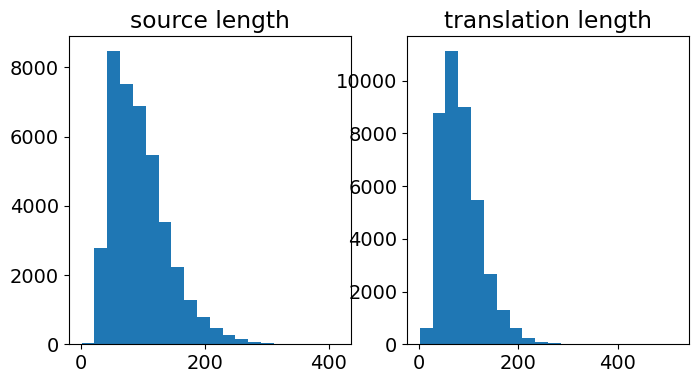

In [81]:
src_length = map(len, [x[0] for x in train_data])
trg_length = map(len, [x[1] for x in train_data])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


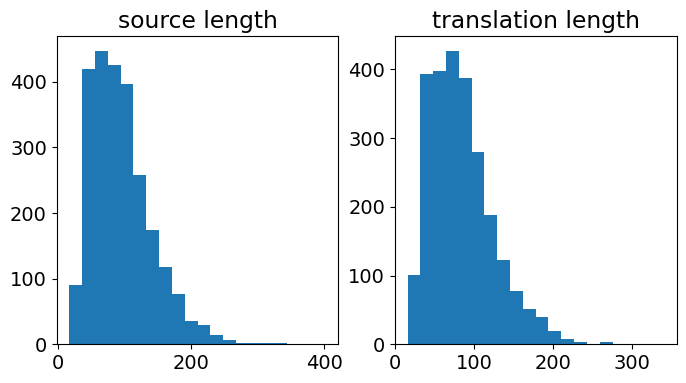

In [82]:
src_length = map(len, [x[0] for x in test_data])
trg_length = map(len, [x[1] for x in test_data])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

## Model Training
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

### Model Code

In [83]:
%%writefile my_network.py
import torch
import torch.nn as nn

import random


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim)

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src):

        embedded = self.embedding(src)

        embedded = self.dropout(embedded)

        output, (hidden, cell) = self.rnn(embedded)

        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(num_embeddings=output_dim, embedding_dim=emb_dim)

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
        )

        self.out = nn.Linear(in_features=hid_dim, out_features=output_dim)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, hidden, cell):

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))

        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert (
            encoder.hid_dim == decoder.hid_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):

        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)

        input = trg[0, :]

        for t in range(1, max_len):

            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = trg[t] if teacher_force else top1

        return outputs


Overwriting my_network.py


### Preparing Training

In [84]:
BATCH_SIZE = 128

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))


In [85]:
for x in train_loader:
    break
print(x)
print(x[0].shape, x[1].shape)

(tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [252,   5,  34,  ...,   5,  67,  21],
        [253,  71,  13,  ..., 119, 207,  25],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]]), tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [ 241,  425, 1869,  ...,   92,   28,   30],
        [ 759,   12,    0,  ...,  425,  215,   27],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]]))
torch.Size([65, 128]) torch.Size([60, 128])


In [86]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [87]:
INPUT_DIM = len(vocab_src)
OUTPUT_DIM = len(vocab_trg)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [88]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9310, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6711, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6711, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [89]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,900,535 trainable parameters


In [90]:
PAD_IDX = vocab_trg['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [91]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in tqdm.tqdm(enumerate(iterator)):
        
        src = batch[0]
        trg = batch[1]
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].reshape(-1)
        # trg[1:].reshape(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [92]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch[0]
            trg = batch[1]

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].reshape(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [93]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [94]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [29]:
%%time

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01


0it [00:00, ?it/s]

0it [00:06, ?it/s]


KeyboardInterrupt: 

## Evaluation

In [95]:
# load trained model

model.load_state_dict(torch.load('tut1-model.pt', map_location=device))

<All keys matched successfully>

In [96]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [97]:
batch = next(iter(test_loader))

In [98]:
for idx in [1,2]:
    src = batch[0][:, idx:idx+1]
    trg = batch[1][:, idx:idx+1]
    generate_translation(src, trg, model, vocab_trg)

Original: each room here will provide you with air conditioning .
Generated: all rooms are air conditioned .

Original: take advantage of the large , free car park .
Generated: free parking is available on site .



In [83]:
#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [99]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_loader)):

        src = batch[0]
        trg = batch[1]

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, vocab_trg) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, vocab_trg) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

20it [00:19,  1.00it/s]


In [100]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

17.568261612092304

# Approach 3: fine-tunning BART

## Data Preparation

In [8]:
bart_name = "facebook/bart-base"
bart_tokenizer = BartTokenizer.from_pretrained(bart_name)

In [9]:
def collate_batch(batch):
    src_texts = [item[0] for item in batch]  
    trg_texts = [item[1] for item in batch]

    tokenizer = bart_tokenizer(
        text=src_texts,
        text_target=trg_texts,
        padding="longest",
        truncation=True,
        return_tensors="pt",
    )

    labels = tokenizer["labels"]
    labels[labels == bart_tokenizer.pad_token_id] = -100

    return {
        "input_ids": tokenizer["input_ids"],
        "attention_mask": tokenizer["attention_mask"],
        "labels": labels,
    }

BATCH_SIZE = 16

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))

## Model Training

In [10]:
from tqdm import tqdm 

def train_epoch(model, data_loader, optimizer, device, train_history=None, valid_history=None):
    model.train()
    total_loss = 0

    history = []

    i = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                        labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
            
        i += 1

    print(f"Average training loss: {total_loss / len(data_loader)}")
    return total_loss / len(data_loader)

def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                            labels=labels)

            loss = outputs.loss
            total_loss += loss.item()

    print(f"Average validation loss: {total_loss / len(data_loader)}")
    return total_loss / len(data_loader)


In [33]:
bart = BartForConditionalGeneration.from_pretrained(bart_name).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(bart):,} trainable parameters')

139420416

In [29]:
num_epochs = 3

optimizer = optim.AdamW(bart.parameters(), lr=5e-6)

best_valid_loss = float('inf')

train_history = []
valid_history = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss = train_epoch(bart, train_loader, optimizer, device, train_history, valid_history)
    valid_loss = eval_model(bart, valid_loader, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bart.state_dict(), 'bart-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

Epoch 1/3


Evaluating:   0%|          | 4/938 [00:28<1:52:11,  7.21s/it]


KeyboardInterrupt: 

## Evaluation

In [12]:
bart.load_state_dict(torch.load('bart-model.pt', map_location=device))

<All keys matched successfully>

In [13]:
original_text = []
generated_text = []

def translate(batch):

    src_ids = batch["input_ids"].to(device)
    src_mask = batch["attention_mask"].to(device)
    labels = batch["labels"]

    outputs = bart.generate(
        src_ids,
        attention_mask=src_mask,
        num_beams=5,
        max_length=100,
        early_stopping=True,
    )

    src_texts = [
        bart_tokenizer.decode(s, skip_special_tokens=True) for s in src_ids
    ]

    translated_texts = [
        bart_tokenizer.decode(o, skip_special_tokens=True) for o in outputs
    ]

    trg_texts = [
        bart_tokenizer.decode(t[t != -100], skip_special_tokens=True)
        for t in labels
    ]

    return src_texts, trg_texts, translated_texts


bart.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):

        src_texts, trg_texts, translated_texts = translate(batch)

        original_text.extend(trg_texts)
        generated_text.extend(translated_texts)

0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
157it [27:00, 10.32s/it]


In [14]:
print(original_text[:5])
print(generated_text[:5])

['It offers well-equipped rooms and a daily breakfast buffet.', 'Each room here will provide you with air conditioning.', 'Take advantage of the large, free car park.', 'Air conditioned rooms are provided with a flat-screen TV, seating area and minibar.', 'Complejo Alcaidia De Magina is located in the charming Andalusian hillside town of Cambil.']
['It offers spacious rooms and a daily buffet breakfast.', 'Each room here will provide you with air conditioning.', 'Free parking is available on site.', 'The air-conditioned rooms feature a flat-screen TV, seating area and minibar.', 'Hotel Complejo Alcaidia De Magina is located in the centre of Cáceres.']


In [15]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

52.708372672512546